# Tutorial for building fraction impacts as baseline for displacement post-processing

In this code, we apply the concept of displacement following a particular level of building damage post impact calculation. Meaning, we first calculate building fraction damages for each event and store the resulting impact matrices together with the exposure dataframe. On this basis, we can postprocess the results and convert thresholds of buildling-fraction damage to displaced population.

This approach stands in contrast to applying the building threshold prior to the impact calculation on the level of the impact functions.

Here, we explore this approach for the coastal flood hazard in 2 countries (PHL, SOM). We use two vulnerability function sources (CIMA/Capra and IVM). Additionally, we test the feasiblity of applying the same approach to event-based hazards (TC).

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Somalia'

In [2]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.1] # filter out rows with basically no population

exp = Exposures(gdf_bem_subcomps.copy())
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf['value'] = 1 # each building type gets value 1

## FL impact functions

### Base Scenario

In [3]:
exp.gdf['impf_FL_cima'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)

In [4]:
exp.gdf['impf_FL_ivm'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)

In [5]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,longitude,latitude,value,impf_FL_cima,impf_FL_ivm
18,194457751,SOM,3,edu_priv,W2,0.281569,0.000852,0.0,0.0,0.0,POINT (43.40417 0.66250),43.404167,0.6625,1,15,2
19,194457751,SOM,3,edu_priv,W1,0.120395,0.000365,0.0,0.0,0.0,POINT (43.40417 0.66250),43.404167,0.6625,1,14,2
24,194457751,SOM,3,edu_pub,W2,3.642231,0.011027,0.0,0.0,0.0,POINT (43.40417 0.66250),43.404167,0.6625,1,15,2
25,194457751,SOM,3,edu_pub,W1,1.557365,0.004715,0.0,0.0,0.0,POINT (43.40417 0.66250),43.404167,0.6625,1,14,2
27,194457751,SOM,3,edu_pub,RS2,0.401901,0.001217,0.0,0.0,0.0,POINT (43.40417 0.66250),43.404167,0.6625,1,6,3


### Perform impact calcs and compare

#### Flood CIMA

In [6]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{cntry}/HISTORICAL/')
HAZ_TYPE = 'FL'

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

In [7]:
# Create the Hazard object
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE,
    files_intensity=list(haz_files),
    src_crs='WGS84',
    attrs={
        'unit': 'm',
        'event_id': np.arange(len(haz_files)),
        'frequency': 1 / rp
    }
)
haz.intensity = haz.intensity/100

In [8]:
#haz.plot_intensity(event=0)

In [9]:
exp.gdf.rename({'impf_FL_cima' : 'impf_FL'}, axis=1, inplace=True)

imp_cima = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, haz).impact(save_mat=True)

In [10]:
imp_cima.imp_mat

<9x1439740 sparse matrix of type '<class 'numpy.float64'>'
	with 943524 stored elements in Compressed Sparse Row format>

#### Coastal flood

In [11]:
haz_CF_dir = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km')

In [12]:
# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(
    exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max())

In [13]:
# load CF hazard phl
CF = coastal_flood_hazard.generate_hazard_object(tiles, haz_CF_dir, 'RCP45', '2020', 'FL')

AttributeError: 'Centroids' object has no attribute 'to_default_crs'

In [18]:
CF.frequency

array([1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  ,
       0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 ,
       0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004,
       0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   ,
       0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 ,
       0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 ,
       0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001,
       1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  ,
       0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 ,
       0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004,
       0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   ,
       0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 ,
       0.02 , 0.01 , 0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 ,
       0.004, 0.001, 1.   , 0.1  , 0.04 , 0.02 , 0.01 , 0.004, 0.001,
       1.   , 0.1  ,

<GeoAxesSubplot:title={'center':'FL max intensity at each point'}>

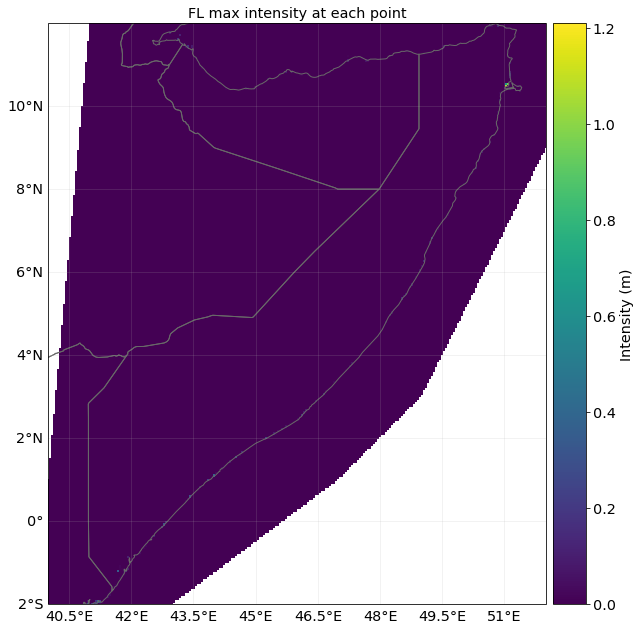

In [17]:
CF.plot_intensity(event=0)

In [10]:
CF.event_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

## TC impact functions

### Base scenario

In [ ]:
exp.gdf['impf_TC_base'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_TCIMPF_HAZUS)

### Min, med, max scenarios

In [ ]:
# we modify the dictionary to point to the "_min", "_med" and "_max" vulnerability functions everywhere 
DICT_TCIMPF_MIN = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'min']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MED = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'med']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MAX = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'max']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}

In [ ]:
exp.gdf['impf_TC_min'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MIN) 

In [ ]:
exp.gdf['impf_TC_med'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MED) 

In [ ]:
exp.gdf['impf_TC_max'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MAX) 

### Perform impact calcs and compare

In [ ]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/present')
haz_TC = TropCyclone.from_hdf5(haz_TC_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [ ]:
TC = haz_TC.select(extent=(
    exp.gdf['longitude'].min(), exp.gdf['longitude'].max(), exp.gdf['latitude'].min(), exp.gdf['latitude'].max()))

In [ ]:
exp.gdf.rename({'impf_TC_base' : 'impf_TC'}, axis=1, inplace=True)

imp_base = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_base'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_min' : 'impf_TC'}, axis=1, inplace=True)

imp_min = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_min'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_med' : 'impf_TC'}, axis=1, inplace=True)

imp_med = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_med'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_max' : 'impf_TC'}, axis=1, inplace=True)

imp_max = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
print(imp_base.aai_agg, imp_min.aai_agg, imp_med.aai_agg, imp_max.aai_agg)